In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import scipy.stats as stats
import pandas as pd
import random
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px
import seaborn as sns

COST_INSULATION = 0.45
TRESHOLD_LEVEL = 0.25 
RESTORATION_COST = 1122 * COST_INSULATION
DWELLING_RESTORATION_LIMIT = 900
RESTORATION_DWELLING_REDUCTION = 0.5
RESTORATION_STEP = 7
GRANULARITY = 'MONTH'  ## ELABORATE ON THIS IN THE FURTHER VERSION
INABILITY_TRESHOLD = 0.1
ARREARS_TRESHOLD = 0.75
MPS_VALUES = [0.1, 0.13, 0.17, 0.20, 0.25] # Marginal Propensity to Save
SHOCK_INDEX = 0
SHOCK_MAGNITUDE = 0.5
SHOCK_STEP = 5
ALLOWENCE_CHEQUE = 50
RESTORATION_BUDGET = 12000
ALLOWENCE_BUDGET = 50000
ALLOWENCE_FROM = 9

class Household(Agent):
    def __init__(self, unique_id, model, disposable_income, dwelling, inability=False, restoration_recieved = False):
        super().__init__(unique_id, model)
        self.disposable_income = disposable_income
        self.dwelling = dwelling
        self.inability = inability
        self.savings = 0  # savings is initialized as 0
        self.arrears = 0
        self.x = random.uniform(0, 1)
        self.y = random.uniform(0, 1)
        self.restoration_recieved = restoration_recieved
        self.allowence_recieved = False
        self.allowence_cheques_sum = 0
        self.mps = 0
        self.daai = 0

    @property
    def energy_cost(self):
        """Calculate and return the current energy cost for the agent."""
        return self.model.energy_price * (self.dwelling)
    
    # Add a new method to update MPS
    def update_mps(self):
        # Get all agent incomes
        incomes = [a.disposable_income for a in self.model.schedule.agents]

        # Calculate the quintile thresholds
        thresholds = np.quantile(incomes, [0.2, 0.4, 0.6, 0.8])

        # Determine which quintile the agent's income belongs to
        quintile = np.digitize(self.disposable_income, thresholds)

        # Set the MPS based on the quintile
        self.mps = MPS_VALUES[quintile]
        
    def step(self):
        """Update the agent's savings in a step."""
        # Calculate energy costs
        energy_costs = self.energy_cost

        self.update_mps()

        # Check if the agent is in arrears
        if energy_costs > self.disposable_income * ARREARS_TRESHOLD:  # now considering arrears if energy cost exceeds 30% of disposable income
            self.arrears += energy_costs
        else:
            self.savings += (self.disposable_income - energy_costs) * self.mps

        # If the agent has arrears
        if self.arrears > 0:
            if self.savings >= self.arrears:  # and if savings can cover it
                self.savings -= self.arrears
                self.arrears = 0
            else:  # if savings cannot cover it
                self.arrears = self.arrears - self.savings  # set arrears to remaining amount
                self.savings = 0

        self.inability = self.energy_cost > self.disposable_income * INABILITY_TRESHOLD  # agent is in inability state if energy costs exceed 10% of income

        # Update disposable income based on growth rate
        growth_rate = np.random.uniform(self.model.growth_boundaries[0], self.model.growth_boundaries[1])
        self.disposable_income *= (1 + growth_rate)


class Country(Model):
    
    @classmethod
    def calculate_gini(cls, incomes):
        incomes = np.sort(incomes)
        n = len(incomes)
        index = np.arange(1, n + 1)
        return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

    @classmethod
    def generate_income_distribution(cls, num_people, median_income, gini_target, lower_bound):
        alpha = (gini_target + 1) / (2 - gini_target)
        for _ in range(10000):
            incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)
            incomes = np.clip(incomes, lower_bound, None)  # None means there is no upper bound
            gini_current = cls.calculate_gini(incomes)
            if np.isclose(gini_current, gini_target, atol=0.01):
                return incomes
            elif gini_current < gini_target:
                alpha *= 0.9
            else:
                alpha *= 1.1

        raise Exception(f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}")
    
    def restoration_program(self):

        global RESTORATION_DWELLING_REDUCTION

        # Sort the agents by income in ascending order
        sorted_agents = sorted(self.schedule.agents, key=lambda agent: (agent.disposable_income, -agent.dwelling))

        for agent in sorted_agents:
            if self.restoration_budget >= self.restoration_cost:
                # Assign the restoration
                agent.restoration_recieved = True

                agent.dwelling *= (1- RESTORATION_DWELLING_REDUCTION)

                # Deduct the restoration cost from the budget
                self.restoration_budget -= self.restoration_cost
            else:
                # If the budget is not sufficient for another restoration, break the loop
                break

    def allowence_program(self):

        # Get a list of all agents' incomes
        incomes = [agent.disposable_income for agent in self.schedule.agents]

        # Compute the 40th percentile of income, which will serve as the cutoff
        income_cutoff = np.percentile(incomes, 40)

        # Sort the agents by income in ascending order
        sorted_agents = sorted(self.schedule.agents, key=lambda agent: (agent.disposable_income))

        for agent in sorted_agents:
            # Check if the agent's income is below the cutoff
            if agent.disposable_income <= income_cutoff and agent.inability:
                if self.allowence_budget >= self.allowence_cheque:
                    # Assign the allowance
                    agent.allowence_recieved = True
                    agent.allowence_cheques_sum += self.allowence_cheque
                    agent.daai = agent.disposable_income - self.allowence_cheque 
                    agent.disposable_income += self.allowence_cheque

                    # Deduct the restoration cost from the budget
                    self.allowence_budget -= self.allowence_cheque
                else:
                    # If the budget is not sufficient for another restoration, break the loop
                    agent.daai = agent.disposable_income
                    break
            else:
                agent.daai = agent.disposable_income

    @staticmethod
    def assign_inability(agents, inability_start):
        """
        Assigns the inability to the agents.
        """
        agents.sort(key=lambda x: x.disposable_income)

        num_agents = len(agents)
        num_unable = int(inability_start * num_agents)
        inability_per_quintile = np.array([2, 1.6, 1.2, 0.8, 0])
        inability_per_quintile *= num_unable / np.sum(inability_per_quintile)
        inability_per_quintile = inability_per_quintile.astype(int)

        assigned_unable = 0
        for i in range(5):  # For each quintile
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = agents[start:end]
            num_unable_quintile = min(inability_per_quintile[i], len(quintile))
            unable_agents = np.random.choice(quintile, num_unable_quintile, replace=False)
            for agent in unable_agents:
                agent.inability = True
            assigned_unable += num_unable_quintile

        # Assign remaining inability if any
        i = 0
        while assigned_unable < num_unable:
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = [agent for agent in agents[start:end] if not agent.inability]
            if quintile:
                agent = np.random.choice(quintile)
                agent.inability = True
                assigned_unable += 1
            else:
                i += 1

    @staticmethod
    def assign_arrears(agents, arrears_start):
        """
        Assigns the arrears to the agents.
        """
        agents.sort(key=lambda x: x.disposable_income)

        num_agents = len(agents)
        num_arrears = int(arrears_start * num_agents)
        arrears_per_quintile = np.array([2, 1.6, 0, 0, 0])
        arrears_per_quintile *= num_arrears / np.sum(arrears_per_quintile)
        arrears_per_quintile = arrears_per_quintile.astype(int)

        assigned_arrears = 0
        for i in range(5):  # For each quintile
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = agents[start:end]
            num_arrears_quintile = min(arrears_per_quintile[i], len(quintile))
            arrears_agents = np.random.choice(quintile, num_arrears_quintile, replace=False)
            for agent in arrears_agents:
                agent.arrears = 2 * ARREARS_TRESHOLD * agent.disposable_income  # assign 0.6 * disposable_income
            assigned_arrears += num_arrears_quintile

        # Assign remaining arrears if any
        i = 0
        while assigned_arrears < num_arrears:
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = [agent for agent in agents[start:end] if not agent.arrears > 0]
            if quintile:
                agent = np.random.choice(quintile)
                agent.arrears = ARREARS_TRESHOLD * agent.disposable_income  # assign 0.6 * disposable_income
                assigned_arrears += 1
            else:
                i += 1


    @staticmethod
    def assign_dwelling(agents, energy_price):
        """
        Assigns the dwelling to the agents.
        """
        buffer = 0.02  # 2% buffer or margin
        all_incomes = [agent.disposable_income for agent in agents]
        quintile_thresholds = np.quantile(all_incomes, [0.2, 0.4])  # Calculate income thresholds for the bottom two quintiles
        for agent in agents:
            min_dwelling, max_dwelling = 500, 2000
            if agent.inability:
                min_dwelling = max(min_dwelling, int(np.ceil((agent.disposable_income * (INABILITY_TRESHOLD + buffer)) / energy_price)))
            else:
                max_dwelling = min(max_dwelling, int((agent.disposable_income * (INABILITY_TRESHOLD - buffer)) / energy_price))

            # Generate a list of feasible dwelling values
            feasible_dwelling = list(range(min_dwelling, max_dwelling + 1))

            # If the list is not empty, select a random dwelling from the list
            if feasible_dwelling:
                agent.dwelling = np.random.choice(feasible_dwelling)
            else:
                agent.dwelling = min_dwelling  # fallback to the min_dwelling if no other options

            # Check income quintile of the agent and if in inability state, increase dwelling size
            if agent.disposable_income < quintile_thresholds[1] and agent.inability:  # If in bottom two quintiles and inability is True
                agent.dwelling = min(max_dwelling, int(agent.dwelling * 1.25))  # Increase dwelling size by 25%, but not more than max_dwelling

    def __init__(self, N, median_income, min_disposal, gini_target, inability_target, arrears_target, growth_boundaries, prices, shares_p, growth_rate_lower_bound, growth_rate_upper_bound, restoration_ACTIVE = False, allowence_ACTIVE = False, price_shock = False):
        self.num_agents = N
        self.median_income = median_income
        self.min_disposal = min_disposal
        self.gini_target = gini_target
        self.inability_target = inability_target
        self.growth_boundaries = growth_boundaries
        self.prices = prices
        self.shares_p = shares_p
        self.growth_rate_lower_bound = growth_rate_lower_bound
        self.growth_rate_upper_bound = growth_rate_upper_bound
        self.price_shock = price_shock
        self.restoration_ACTIVE = restoration_ACTIVE
        self.allowence_ACTIVE = allowence_ACTIVE
        self.restoration_cost = RESTORATION_COST
        self.restoration_budget = RESTORATION_BUDGET
        self.allowence_budget = ALLOWENCE_BUDGET
        self.allowence_cheque = ALLOWENCE_CHEQUE
        self.arrears_target = arrears_target
        # Other initialization code...
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
        agent_reporters={"Dwelling": "dwelling", 
                        "Income": "disposable_income",
                        "Inability": "inability",
                        "Savings":"savings",
                        "X":"x",
                        "Y":"y",
                        "MPS":"mps",
                        "DAAI":"daai",
                        "Allowence":"allowence_cheques_sum",
                        "Restoration Aid Recieved":"restoration_recieved",
                        "Arrears":"arrears",
                        "EnergyCost": "energy_cost"},
        model_reporters = {
                        "Inability": lambda model: sum(agent.inability for agent in model.schedule.agents) / model.num_agents,
                        "Arrears": lambda model: sum(agent.arrears for agent in model.schedule.agents) / model.num_agents,
                        "Allowences": lambda model: sum(agent.allowence_cheques_sum for agent in model.schedule.agents) / model.num_agents,
                        "Energy Price": lambda model: model.energy_price,
                        "Price Yellow Fuel": lambda model: model.prices[0],
                        "Price Brown Fuel": lambda model: model.prices[1],
                        "Average Dwelling Over Time": lambda model: sum(agent.dwelling for agent in model.schedule.agents) / model.num_agents,
                        "Restorations": lambda m: sum([agent.restoration_recieved for agent in m.schedule.agents])}
                        )

        # Generate disposable incomes and assign dwelling and technology
        incomes = self.generate_income_distribution(self.num_agents, self.median_income, self.gini_target, self.min_disposal)

        self.initial_energy_price = np.dot(self.prices, self.shares_p)

 
        # Create agents
        agents = []
        for i in range(self.num_agents):
            a = Household(i, self, disposable_income=incomes[i], dwelling=0, inability=False)
            agents.append(a)

        
        self.assign_inability(agents, self.inability_target)
        self.assign_dwelling(agents, self.energy_price)
        self.assign_arrears(agents, self.arrears_target)
        self.assign_mps(agents)

        # Add agents to the model
        for a in agents:
            self.schedule.add(a)

    @staticmethod
    def assign_mps(agents):
        """
        Assigns the MPS to the agents based on their income quintile.
        """
        agents.sort(key=lambda x: x.disposable_income)

        num_agents = len(agents)
        for i in range(5):  # For each quintile
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile_agents = agents[start:end]
            for agent in quintile_agents:
                agent.mps = MPS_VALUES[i]

    @property
    def energy_price(self):
        """Calculate and return the current energy price."""
        return np.dot(self.prices, self.shares_p)

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)  # Collect data before updating the prices

        # Update prices based on unique growth rates
        growth_rates = np.random.uniform(self.growth_rate_lower_bound, self.growth_rate_upper_bound)

        self.prices = self.prices * (1 + growth_rates)

        if self.schedule.steps == SHOCK_STEP and self.price_shock == True:
            self.prices[SHOCK_INDEX] *= (1 + SHOCK_MAGNITUDE)

        # Execute the restoration program if it is enabled
        if self.schedule.steps == RESTORATION_STEP and self.restoration_ACTIVE:
            self.restoration_program()

        if self.schedule.steps >= ALLOWENCE_FROM and self.allowence_ACTIVE:
            self.allowence_program()

        self.schedule.step()

N, median_income, min_disposal, gini_target, inability_target, arrears_target, growth_boundaries, prices, shares_p, growth_rate_lower_bound, growth_rate_upper_bound, restoration_budget, restoration_ACTIVE = False

In [3]:

model = Country(1000, 1700, 900, 0.30, 0.2, 0.07, [0,0.05], np.array([0.2, 0.06]), np.array([0.7, 0.3]), np.array([-0.01, -0.01]), np.array([0.02, 0.01]), allowence_ACTIVE = True, restoration_ACTIVE= True, price_shock= True)
 
for i in range(15):
    model.step()


agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()


In [4]:
agent_data[agent_data['Restoration Aid Recieved'] == True]

Dwelling       Income  Inability      Savings         X  \
Step AgentID                                                            
8    16          820.0  1032.886602       True     0.000000  0.682177   
     104        1000.0  1017.100923       True   483.104565  0.901101   
     115        1000.0  1034.233040       True   477.975186  0.997938   
     144         250.0   992.312717      False     0.000000  0.185849   
     207         833.0  1009.556913       True     0.000000  0.461229   
...                ...          ...        ...          ...       ...   
14   855        1000.0  1396.810158       True  1017.632026  0.574428   
     879         966.0  1466.910629       True  1136.979206  0.698279   
     899         250.0  1224.138746      False  1328.244880  0.964778   
     921         250.0  1130.672941      False  1277.285492  0.822785   
     959         250.0  1142.158218      False  1278.436892  0.552560   

                     Y   MPS         DAAI  Allowence  \
Step AgentID                                           
8    16       0.390436  0.10     0.000000          0   
     104      0.543715  0.10     0.000000          0   
     115      0.115201  0.10     0.000000          0   
     144      0.858285  0.10     0.000000          0   
     207      0.357630  0.10     0.000000          0   
...                ...   ...          ...        ...   
14   855      0.422281  0.10  1255.139635        250   
     879      0.917347  0.13  1322.352538        250   
     899      0.784749  0.10  1173.411783          0   
     921      0.607798  0.10  1109.701629          0   
     959      0.160493  0.10  1092.674743          0   

              Restoration Aid Recieved     Arrears  EnergyCost  
Step AgentID                                                    
8    16                           True  830.143816  195.478014  
     104                          True    0.000000  238.387822  
     115                          True    0.000000  238.387822  
     144                          True  640.202917   59.596955  
     207                          True  829.910329  198.577055  
...                                ...         ...         ...  
14   855                          True    0.000000  245.530926  
     879                          True    0.000000  237.182874  
     899                          True    0.000000   61.382731  
     921                          True    0.000000   61.382731  
     959                          True    0.000000   61.382731  

[161 rows x 12 columns]

In [5]:
# agent_data[agent_data['Allowence'] > 0]

In [6]:
# import matplotlib.pyplot as plt
# from ipywidgets import interact


# # reset index to make X, Y, Inability into columns
# df = agent_data.reset_index()

# def plot_step(step):
#     df_step = df[df['Step'] == step]
#     fig, ax = plt.subplots()
#     colors = ['red' if inability else 'green' for inability in df_step['Inability']]
#     ax.scatter(df_step['X'], df_step['Y'], color=colors)
#     plt.show()

# # create slider for steps
# interact(plot_step, step=(0, df['Step'].max()))

In [7]:
agent_id_8_data = agent_data.xs(915, level="AgentID")
agent_id_8_data

,Dwelling,Income,Inability,Savings,X,Y,MPS,DAAI,Allowence,Restoration Aid Recieved,Arrears,EnergyCost
Step,,,,,,,,,,,,
0,1871.0,1295.242754,True,0.000000,0.014335,0.271409,0.17,0.000000,0,False,0.0,295.618000
1,1871.0,1355.375208,True,169.754692,0.014335,0.271409,0.17,0.000000,0,False,0.0,296.685744
2,1871.0,1375.533046,True,349.634133,0.014335,0.271409,0.17,0.000000,0,False,0.0,297.260846
3,1871.0,1441.335055,True,533.289870,0.014335,0.271409,0.17,0.000000,0,False,0.0,295.205183
4,1871.0,1510.137337,True,727.334173,0.014335,0.271409,0.17,0.000000,0,False,0.0,299.897976
5,1871.0,1515.758660,True,933.207082,0.014335,0.271409,0.17,0.000000,0,False,0.0,299.120225
6,1871.0,1587.901307,True,1117.323494,0.014335,0.271409,0.17,0.000000,0,False,0.0,432.720946
7,1871.0,1627.161958,True,1312.397981,0.014335,0.271409,0.17,0.000000,0,False,0.0,440.404322
8,1871.0,1656.983038,True,1513.191499,0.014335,0.271409,0.17,0.000000,0,False,0.0,446.023614


In [8]:
# Model-level data
fig = sp.make_subplots(rows=int(len(model_data.columns)/2), cols=2, subplot_titles=model_data.columns)
color_discrete_sequence=px.colors.qualitative.Plotly  # Default color sequence

for i, col in enumerate(model_data.columns, start=1):
    fig.add_trace(go.Scatter(x=model_data.index, y=model_data[col], mode='lines', name=col, line=dict(color=color_discrete_sequence[(i-1) % len(color_discrete_sequence)])), row=int((i-1)/2)+1, col=((i-1)%2)+1)

fig.update_layout(height=400*int(len(model_data.columns)/2), width=1600, title_text="", showlegend=False)
fig.show()

# For Price1, Price2, and Energy Price
fig = go.Figure()
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Price Yellow Fuel'], mode='lines', name='Price Yellow Fuel', line=dict(color='gold')))
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Price Brown Fuel'], mode='lines', name='Price Brown Fuel', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Energy Price'], mode='lines', name='Energy Price', line=dict(color='green')))

fig.update_layout(title='Prices over time', xaxis_title='Time (steps)', yaxis_title='Price', showlegend=False)
fig.show()


In [20]:
# Model-level data
fig = sp.make_subplots(rows=int(len(model_data.columns)/2), cols=2, subplot_titles=model_data.columns)
color_discrete_sequence=px.colors.qualitative.Plotly  # Default color sequence

for i, col in enumerate(model_data.columns, start=1):
    fig.add_trace(go.Scatter(x=model_data.index, y=model_data[col], mode='lines', name=col, line=dict(color=color_discrete_sequence[(i-1) % len(color_discrete_sequence)])), row=int((i-1)/2)+1, col=((i-1)%2)+1)

fig.update_layout(height=400*int(len(model_data.columns)/2), width=1600, title_text="", showlegend=False)

# Update the subplot titles
for i in fig['layout']['annotations']:
    i['font'] = dict(size=24, color='black', family="Arial")  # Adjust size, color, and font here

fig.show()


In [9]:
# Model-level data
fig = sp.make_subplots(rows=int(len(model_data.columns)/2), cols=2, subplot_titles=model_data.columns)
color_discrete_sequence=px.colors.qualitative.Plotly  # Default color sequence

for i, col in enumerate(model_data.columns, start=1):
    fig.add_trace(go.Scatter(x=model_data.index, y=model_data[col], mode='lines', name=col, line=dict(color=color_discrete_sequence[(i-1) % len(color_discrete_sequence)])), row=int((i-1)/2)+1, col=((i-1)%2)+1)

fig.update_layout(height=400*int(len(model_data.columns)/2), width=1600, title_text="", showlegend=False, 
                  title_font=dict(size=24, color='black', family="Courier New, monospace"), # Adjust size and font here
                  )

fig.show()

# For Price1, Price2, and Energy Price
fig = go.Figure()
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Price Yellow Fuel'], mode='lines', name='Price Yellow Fuel', line=dict(color='gold')))
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Price Brown Fuel'], mode='lines', name='Price Brown Fuel', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Energy Price'], mode='lines', name='Energy Price', line=dict(color='green')))

fig.update_layout(title='Prices over time', xaxis_title='Time (steps)', yaxis_title='Price', showlegend=False,
                  title_font=dict(size=24, color='black', family="Courier New, monospace"), # Adjust size and font here
                  )

fig.show()


In [10]:
import matplotlib.pyplot as plt
from ipywidgets import interact


# reset index to make X, Y, Inability into columns
df = agent_data.reset_index()

def plot_step(step):
    df_step = df[df['Step'] == step]
    fig, ax = plt.subplots()
    colors = ['red' if inability else 'green' for inability in df_step['Inability']]
    ax.scatter(df_step['X'], df_step['Y'], color=colors)
    plt.show()

# create slider for steps
interact(plot_step, step=(0, df['Step'].max()))

interactive(children=(IntSlider(value=7, description='step', max=14), Output()), _dom_classes=('widget-interac…

<function __main__.plot_step(step)>

In [11]:
def plot_dwelling(step):
    df_step = df[df['Step'] == step].copy()  # Make a copy to prevent the warning
    
    # Assuming income and dwelling are attributes in your DataFrame
    try:
        df_step.loc[:, 'Income Quintile'] = pd.qcut(df_step['Income'], 5, labels=False, duplicates='drop')
        average_dwelling = df_step.groupby('Income Quintile')['Dwelling'].mean().reset_index()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Income Quintile', y='Dwelling', data=average_dwelling)
        plt.title('Average Dwelling by Income Quintile at Step ' + str(step))
        plt.xlabel('Income Quintile')
        plt.ylabel('Average Dwelling')
        plt.show()
    except ValueError as e:
        print(f"Could not plot for step {step} due to error: {e}")


In [12]:
# create slider for steps
interact(plot_dwelling, step=(0, df['Step'].max()))


interactive(children=(IntSlider(value=7, description='step', max=14), Output()), _dom_classes=('widget-interac…

<function __main__.plot_dwelling(step)>

In [13]:
def plot_dwelling(step):
    df_step = df[df['Step'] == step].copy()  # Make a copy to prevent the warning
    
    # Assuming income and dwelling are attributes in your DataFrame
    try:
        df_step.loc[:, 'Income Quintile'] = pd.qcut(df_step['Income'], 5, labels=False, duplicates='drop')
        average_dwelling = df_step.groupby('Income Quintile')['Dwelling'].mean().reset_index()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Income Quintile', y='Dwelling', data=average_dwelling)
        plt.title('Average Dwelling by Income Quintile at Step ' + str(step))
        plt.xlabel('Income Quintile')
        plt.ylabel('Average Dwelling')
        plt.show()
    except ValueError as e:
        print(f"Could not plot for step {step} due to error: {e}")


In [14]:
from IPython.display import display

def plot_all(step):
    df_step = df[df['Step'] == step].copy()  # Make a copy to prevent the warning
    
    # Assuming income and dwelling are attributes in your DataFrame
    try:
        df_step.loc[:, 'Income Quintile'] = pd.qcut(df_step['Income'], 5, labels=False, duplicates='drop')
        
        fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # Create a subplot with 2 rows and 2 columns

        # Plot Inability
        colors = ['red' if inability else 'green' for inability in df_step['Inability']]
        axs[0, 0].scatter(df_step['X'], df_step['Y'], color=colors)
        axs[0, 0].set_title('Inability at Step ' + str(step))
        
        # Plot Average Disposable Income by Income Quintile
        average_inability = df_step.groupby('Income Quintile')['Inability'].mean().reset_index()
        sns.barplot(x='Income Quintile', y='Inability', data=average_inability, ax=axs[0, 1])
        axs[0, 1].set_title('Average Inability by Income Quintile at Step ' + str(step))
        axs[0, 1].set_xlabel('Income Quintile')
        axs[0, 1].set_ylabel('Average Inability')

        # Plot Total Disposable Income by Income Quintile
        total_income = df_step.groupby('Income Quintile')['Income'].mean().reset_index()
        sns.barplot(x='Income Quintile', y='Income', data=total_income, ax=axs[1, 0])
        axs[1, 0].set_title('Average Disposable Income by Income Quintile at Step ' + str(step))
        axs[1, 0].set_xlabel('Income Quintile')
        axs[1, 0].set_ylabel('Average Disposable Income')
        
        # Leave last plot empty (or you can add something else here)
        axs[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Could not plot for step {step} due to error: {e}")

# create slider for steps
interact(plot_all, step=(0, df['Step'].max()))


interactive(children=(IntSlider(value=7, description='step', max=14), Output()), _dom_classes=('widget-interac…

<function __main__.plot_all(step)>

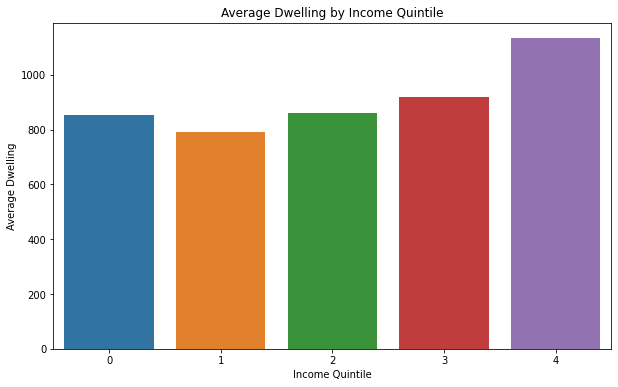

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'agent_df' is your DataFrame
agent_df = model.datacollector.get_agent_vars_dataframe()

# Calculate quintiles
agent_df['Income Quintile'] = pd.qcut(agent_df['Income'], 5, labels=False)

# Calculate average dwelling by income quintile
average_dwelling = agent_df.groupby('Income Quintile')['Dwelling'].mean().reset_index()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Income Quintile', y='Dwelling', data=average_dwelling)
plt.title('Average Dwelling by Income Quintile')
plt.xlabel('Income Quintile')
plt.ylabel('Average Dwelling')
plt.show()

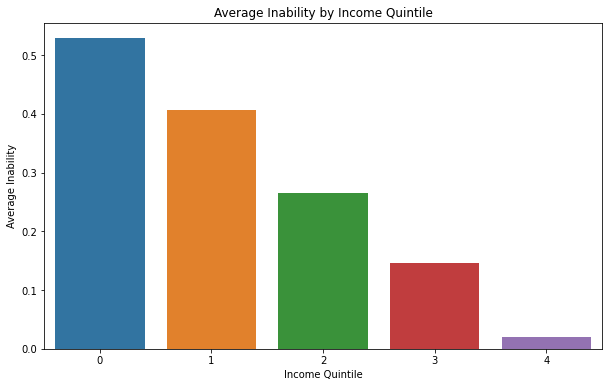

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'agent_df' is your DataFrame
agent_df = model.datacollector.get_agent_vars_dataframe()

# Calculate quintiles
agent_df['Income Quintile'] = pd.qcut(agent_df['Income'], 5, labels=False)

# Calculate average dwelling by income quintile
average_dwelling = agent_df.groupby('Income Quintile')['Inability'].mean().reset_index()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Income Quintile', y='Inability', data=average_dwelling)
plt.title('Average Inability by Income Quintile')
plt.xlabel('Income Quintile')
plt.ylabel('Average Inability')
plt.show()

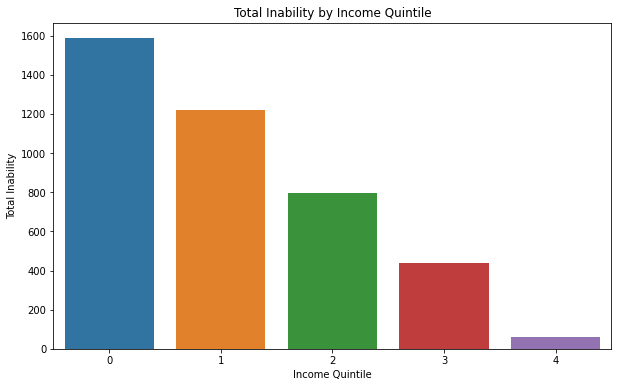

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'agent_df' is your DataFrame
agent_df = model.datacollector.get_agent_vars_dataframe()

# Calculate quintiles
agent_df['Income Quintile'] = pd.qcut(agent_df['Income'], 5, labels=False)

# Calculate average dwelling by income quintile
average_dwelling = agent_df.groupby('Income Quintile')['Inability'].sum().reset_index()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Income Quintile', y='Inability', data=average_dwelling)
plt.title('Total Inability by Income Quintile')
plt.xlabel('Income Quintile')
plt.ylabel('Total Inability')
plt.show()